In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from pprint import pprint
import importlib
import community
import seaborn as sns
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim
import copy
import itertools

Using Theano backend.
C:\Users\faisal\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Reshape
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [3]:
importlib.reload(gr)

<module 'graph' from 'C:\\Users\\faisal\\PycharmProjects\\linkPrediction\\graph.py'>

In [4]:
#word_vectors = KeyedVectors.load_word2vec_format('pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin', binary=True)

In [5]:
domain = ['apnea','obesity']
filepath=['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv']
graphpath='C:/Users/faisal/PycharmProjects/linkPrediction/graphs'
datapath='C:/Users/faisal/PycharmProjects/linkPrediction/dataframes'
modelpath='C:/Users/faisal/PycharmProjects/linkPrediction/models'
column_split=['keyword','author_name','affiliation_1','affiliation_2','country']
#time=[parent_start_year, train_start_year, test_start_year, total_test_period_in_year, total_year_in_each_iteration]
time=[1980,2006,2015,1,1,20]
df, key_list = ut.load_dataset(filepath, column_split)

In [27]:
#dynamic train graphs and test graph build and save in disk 
importlib.reload(gr)
gr.dynamic_train_test_graph_build(df, key_list, graphpath, time)

453
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1991.gpickle saved, nodes: 54 edges: 60
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1992.gpickle saved, nodes: 64 edges: 68
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1993.gpickle saved, nodes: 75 edges: 88
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1994.gpickle saved, nodes: 94 edges: 78
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1995.gpickle saved, nodes: 132 edges: 170
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1996.gpickle saved, nodes: 155 edges: 219
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1997.gpickle saved, nodes: 149 edges: 163
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1998.gpickle saved, nodes: 149 edges: 180
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1999.gpickle saved, nodes: 167 edges: 165
C:/Users/faisal/PycharmProjects/

In [6]:
#load all graphs
time=[1980,2006,2015,1,1,20]
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, time)

C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2006.gpickle loaded, nodes: 79 edges: 56
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2007.gpickle loaded, nodes: 400 edges: 699
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2008.gpickle loaded, nodes: 459 edges: 773
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2009.gpickle loaded, nodes: 470 edges: 688
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2010.gpickle loaded, nodes: 496 edges: 786
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2011.gpickle loaded, nodes: 536 edges: 977
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2012.gpickle loaded, nodes: 584 edges: 1054
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2013.gpickle loaded, nodes: 634 edges: 1280
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2014.gpickle loaded, nodes: 583 edges: 1144
C:/Users/faisal/Py

In [ ]:
importlib.reload(fs)
importlib.reload(cl)

freq=5
time=[1980,2006,2015,1,1,10]
train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq)
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

pos in time series: 1309 neg in time series: 5596 pos-neg ratio: 0.23391708363116512 total: 6905
dist_aut_art: 7.173438117353872 dist_y_weight: 10.809461544623215


In [147]:
ts = time[1]
te = time[2]

row = train_data[ts].columns.values.tolist()
feature_names = row[2:len(row)]
all_combinations = itertools.chain(*[itertools.combinations(feature_names, i + 1)
                                     for i, _ in enumerate(feature_names)])
feature_list = list(all_combinations)
selective_features =  set(['type1','type','pref'])
domain_info =  domain[0]+str(ts)+"-"+str(te)+"-"
models  = []
results = []
con = [20,64]
batch_size = con[1]
for feature in feature_list:
    columns_drop = list(set(feature_names).difference(set(feature)))
    if len(feature)==1 and feature[0] in selective_features:
        model_name = '+'.join(feature)
        model_name = domain_info+model_name
        pruned_data = copy.deepcopy(train_data)
        pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)
        X,y, data_len_dm = cl.reshape_feature_data_for_classification(pruned_data, edge_list, time)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        model = cl.classification_model(X_train, X_test, y_train, y_test, data_len_dm, con, model_name)
        results.append(cl.model_evaluate(model, X_test, y_test, batch_size, model_name))
        model_file_name = os.path.join(modelpath, model_name + ".h5")
        model.save(model_file_name)
        models.append(model_name)
        print(model_file_name)

X shape: (6885, 9, 1) y shape: (6885,)
2066/2066 [==============================] - 0s 16us/step
C:/Users/faisal/PycharmProjects/linkPrediction/models\apnea2006-2015-type.h5
X shape: (6885, 9, 1) y shape: (6885,)
2066/2066 [==============================] - 0s 23us/step
C:/Users/faisal/PycharmProjects/linkPrediction/models\apnea2006-2015-type1.h5
X shape: (6885, 9, 1) y shape: (6885,)
2066/2066 [==============================] - 0s 23us/step
C:/Users/faisal/PycharmProjects/linkPrediction/models\apnea2006-2015-pref.h5


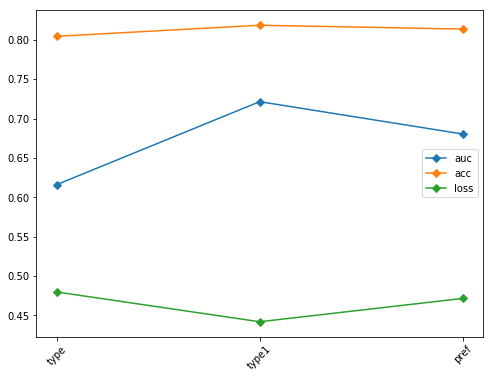

In [148]:
#result
model_names = []
loss = []
acc = []
auc = []
ff = set(['false positive','true positive'])
for row in results:
    for i,r in row.items():
        if i not in ff:
            #print(i,":",row[i])
            pass
    model_names.append(row['model name'].split('-')[2])
    loss.append(row['test score'])
    acc.append(row['test accuracy'])
    auc.append(row['auc'])
    #print()
    
#plot result
plt_for = [auc,acc,loss]
plt_for_name = ['auc','acc','loss']
plt.figure(figsize=(8,6))
for i,name in enumerate(plt_for):
    #plt.title(plt_for_name[i])
    plt.xticks(range(len(model_names)), model_names, rotation=45)
    plt.plot(name, '-D',label = plt_for_name[i])
plt.legend(loc='best')
no=1
fig_name = domain_info+'total feature'+str(no)+'-'+'freq-'+str(freq)+'parent-'+str(time[4])
fig_file_name = os.path.join(datapath, fig_name + ".png")
plt.savefig(fig_file_name)
plt.show()

In [149]:
auc

[0.616071534951329, 0.7214251885477356, 0.6803706318285258]

In [122]:
#specific feature set classification
importlib.reload(fs)
importlib.reload(cl)
freq=5
time=[1980,2006,2015,1,1,20]
train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq)
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

pos in time series: 1309 neg in time series: 5596 pos-neg ratio: 0.23391708363116512 total: 6905
dist_aut_art: 7.173438117353872 dist_y_weight: 10.809461544623215


In [125]:
t=2012
#train_data[t].loc[train_data[t]['label']==0,['type1','pref']]

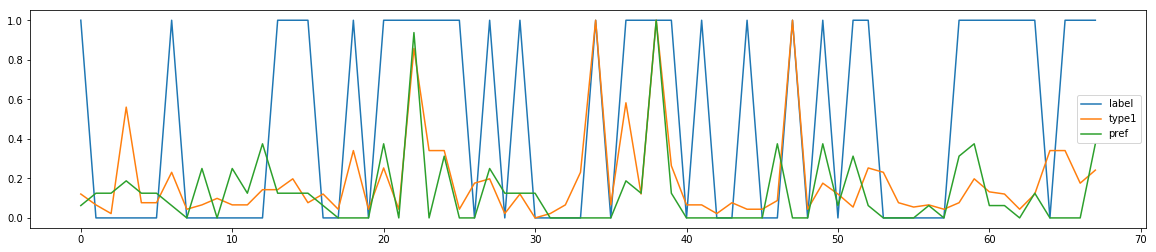

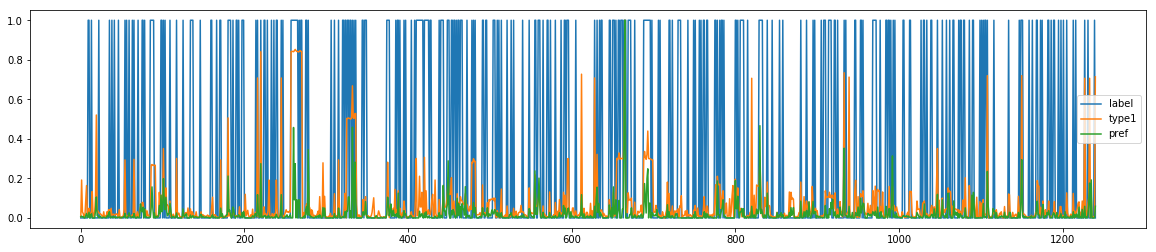

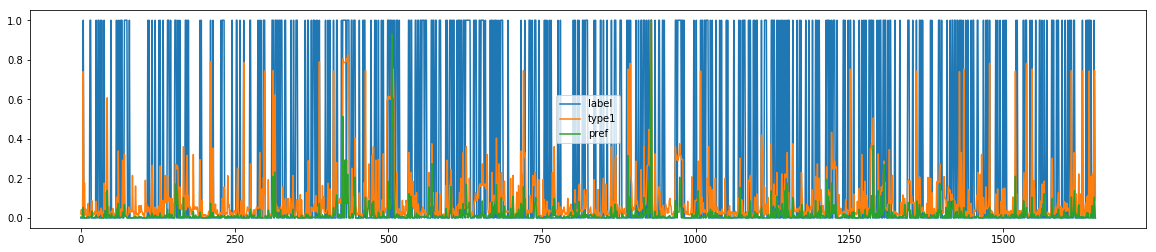

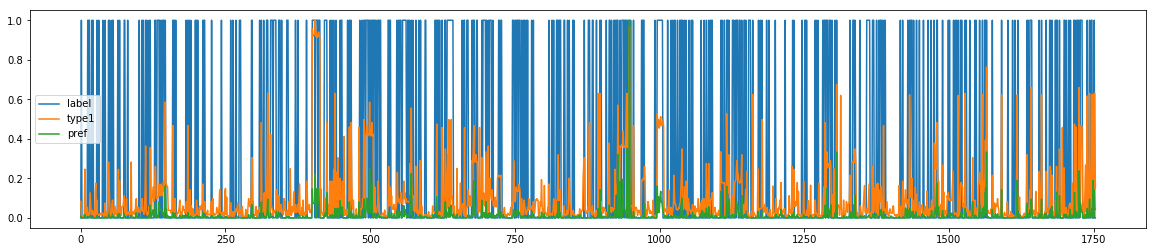

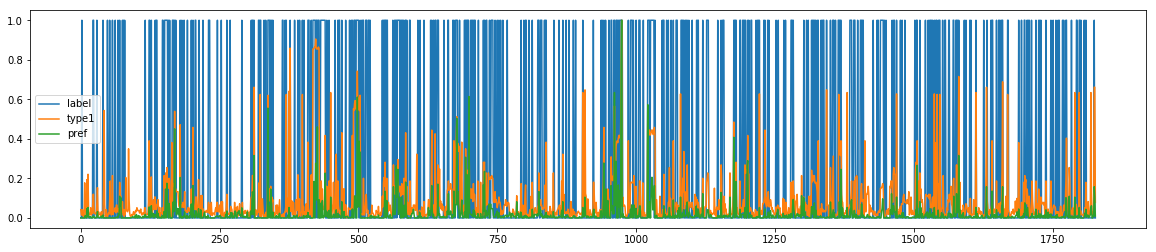

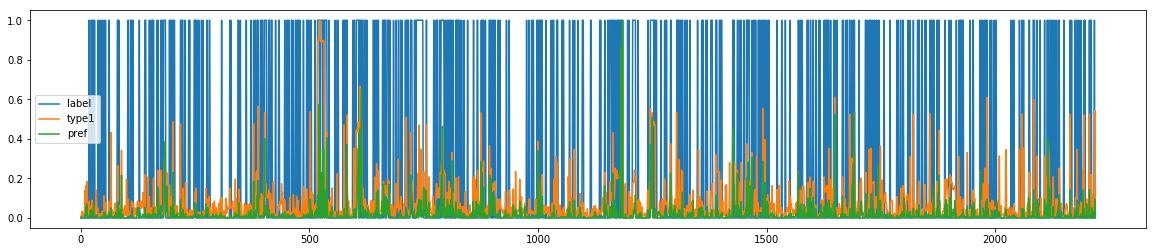

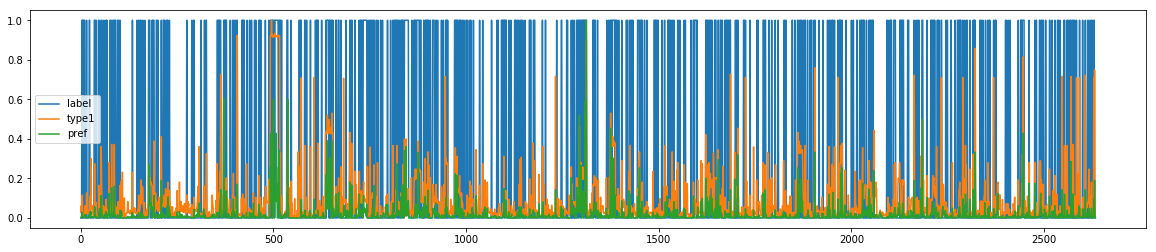

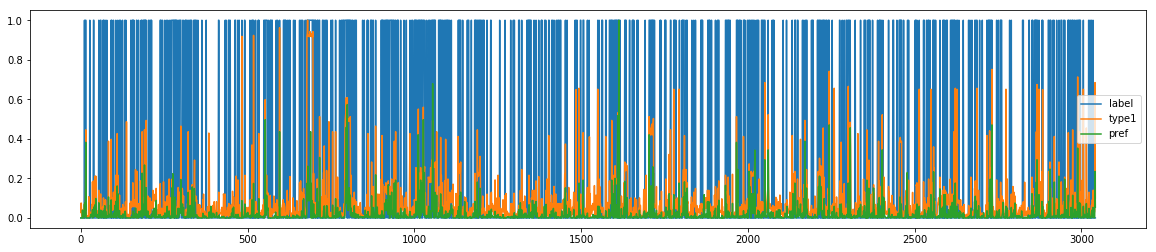

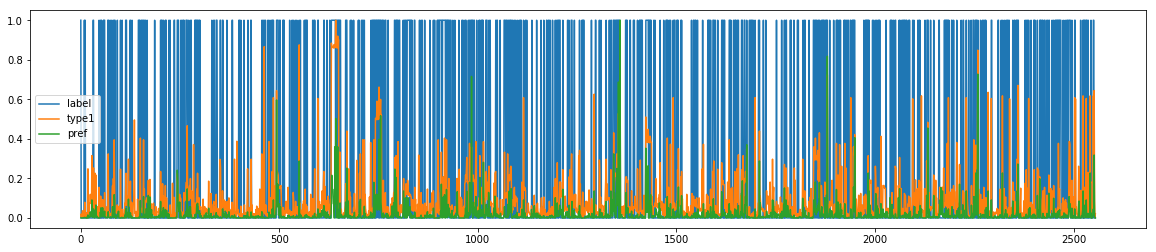

In [136]:
ts = time[1]
te = time[2]
for t in range(ts,te,1):
    train_data[t]['type1'] = ut.min_max_norm(train_data[t]['type1'])
    train_data[t]['aut-pref']=train_data[t]['aut']+train_data[t]['part_cnt']
    train_data[t].loc[train_data[t]['label']>=0,['label','aut-pref','type1','pref']][['label','type1','pref']].plot(figsize=(20,4))

In [38]:
ts = time[1]
te = time[2]
row = train_data[ts].columns.values.tolist()
feature_names = row[2:len(row)]
con = [2,64]
batch_size = con[1]
#feature define
feature = ['pref','type']
model_name = '+'.join(feature)
domain_info =  domain[0]+str(ts)+"-"+str(te)+"-"
model_name = domain_info+model_name
columns_drop = list(set(feature_names).difference(set(feature)))
pruned_data = copy.deepcopy(train_data)
pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)
X,y, data_len_dm = cl.reshape_feature_data_for_classification(pruned_data, edge_list, time)

X shape: (6891, 9, 2) y shape: (6891,)


In [137]:
ts = time[1]
te = time[2]
row = train_data[ts].columns.values.tolist()
feature_names = row[2:len(row)]
con = [2,64]
batch_size = con[1]
#feature define
feature = ['type1']
model_name = '+'.join(feature)
domain_info =  domain[0]+str(ts)+"-"+str(te)+"-"
model_name = domain_info+model_name
columns_drop = list(set(feature_names).difference(set(feature)))
pruned_data = copy.deepcopy(train_data)
pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)
X,y, data_len_dm = cl.reshape_feature_data_for_classification(pruned_data, edge_list, time)

#train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model = cl.classification_model(X_train, X_test, y_train, y_test, data_len_dm, con, model_name)
result = cl.model_evaluate(model, X_test, y_test, batch_size, model_name)

#evaluation result
not_show = set(['false positive','true positive'])
for i,r in result.items():
    if i not in not_show:
        print(i,":",result[i])

X shape: (6905, 9, 1) y shape: (6905,)
2072/2072 [==============================] - 0s 29us/step
model name : apnea2006-2015-type1
test score : 0.5003593421350575
test accuracy : 0.8088803086501751
auc : 0.2951275885345098


In [24]:
#feature inclusion testing
importlib.reload(fs)
importlib.reload(cl)
freq=10
train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq)
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

pos in time series: 1289 neg in time series: 10875 pos-neg ratio: 0.11852873563218391 total: 12164
dist_aut_art: 3.4010361772676156 dist_y_weight: 5.561200890119386
